In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_grew import ChromosomeOp, OperationBlock, CNN, Inputs, HyperParams, Merger, MaxPooling, AvPooling
from GA.geneticAlgorithm import TwoLevelGA


Using TensorFlow backend.


In [2]:
# Chromosome parameters
ChromosomeOp._max_initial_blocks = 5
ChromosomeOp._grow_prob = 0.15
ChromosomeOp._decrease_prob = 0.25

Merger._projection_type = ['normal', 'extend'][1]
MaxPooling._admited_sizes = [2, 3, 5]
AvPooling._admited_sizes = [2, 3, 5]

HyperParams._GROW_RATE_LIMITS = [1.5, 3.]
HyperParams._N_CELLS = [1, 2, 3]
HyperParams._N_BLOCKS = [1, 2, 3]
HyperParams. _STEM = [16, 32, 64]

OperationBlock._change_op_prob = 0.15
OperationBlock._change_concat_prob = 0.15

CNN.filters_mul_range = [0.5, 1.2]
CNN.possible_activations = ['relu', 'elu', 'prelu']
CNN.dropout_range = [0, 0.7]
CNN.possible_k = [1, 3, 5]
CNN.k_prob = 0.2
CNN.drop_prob = 0.2
CNN.filter_prob = 0.2
CNN.act_prob = 0.2

Inputs._mutate_prob = 0.5

    
data_folder = '../../datasets/MNIST_variations'
command = 'python3 ../train_gen.py'
verbose = 0
experiments_folder = '../../exp_op_coding2'

gpus = 2

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../exps_testing'
gpus = 1
skip = 1
'''

"\ndata_folder = '/home/daniel/datasets/MNIST_variations'\ncommand = 'python ./../train_gen.py'\nverbose = 1\nexperiments_folder = '../exps_testing'\ngpus = 1\nskip = 1\n"

In [3]:
fitness_cnn = FitnessCNN()    

In [4]:
c = ChromosomeOp.random_individual()
print(c)


||CNN|F:0.9|K:1|A:prelu|D:0.40||woCAT||1||
||CNN|F:1.2|K:1|A:prelu|D:0.40||woCAT||10||
||CNN|F:0.9|K:1|A:relu|D:0.25||SUM||011||
HP->|GR:2.82|CELL:1|BLOCK:2|STEM:64|LR:-7.8



In [5]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
generations = -1
population_first_level = 20
population_second_level = 8
training_hours = 24
save_progress = True
maximize_fitness = False
statistical_validation = False
frequency_second_level = 3
start_level2 = 1


# Fitness params
epochs = 15
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 0
warm_up_epochs = 0
base_lr = 0.05
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 75
include_time = True
test_eps=200

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['cifar10']

In [6]:
#experiments_folder = '../../exp_cifar10_time'
experiments_folder = '../../exp_cifar10_grow_timefit'

description = "Filter grow exponentially respect to grow_rate.\nCells, blocks and Stem added.\nTime in fitness calculation"
description += "\nWo maxpooling and av pooling.\nPrecision filter grow of cnn's reduced to 0.1"
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        # Load data
        num_clases = 100 if dataset == 'cifar100' else 10
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

        fitness_cnn.save(fitness_file)
    except:
        # Load data
        num_clases = 100 if dataset == 'cifar100' else 10
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        generational.print_genetic(description)

        
    ti_all = time()
    print(generational.generation)
    print(generational.num_generations)
    raise Error
    if generational.generation < generational.num_generations:
        generational.training_hours = 12
        winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))
    



EVOLVING IN DATASET cifar10 ...

Loading file ../../exp_cifar10_grow_timefit/cifar10/genetic/0_2020-01-14-20:13/GA_experiment
(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
12
10000


NameError: name 'Error' is not defined

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
experiments_folder = '../../exp_cifar10_time'
dataset = datasets[0]
exp_folder = os.path.join(experiments_folder, dataset)
folder = os.path.join(exp_folder, 'genetic')


generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
generational.finishing_evolution(show=True)


In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

winner = generational.best_individual['winner']
fit = generational.best_individual['best_fit']
test = generational.best_individual["test"]
print(winner)
print(1 - fit)
print(1 - test, test)



||CNN|F:0.6|K:1|A:relu|D:0.10||woCAT||1||
||CNN|F:0.9|K:1|A:relu|D:0.05||woCAT||01||
||CNN|F:0.8|K:5|A:relu|D:0.35||SUM||011||
||CNN|F:0.8|K:5|A:relu|D:0.10||SUM||1001||
HP->|GR:2.57|CELL:2|BLOCK:3|STEM:64|LR:0.1

0.938193
0.9551 0.0449


In [8]:
# Load data
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


In [9]:
winner = generational.best_individual['winner']
fit = generational.best_individual['best_fit']
test = generational.best_individual["test"]
print(winner)
print(1 - fit)
print(1 - test)

gen1 = "||CNN|F:0.98|K:1|A:relu|D:0.50||woCAT||1||\n\
||CNN|F:0.83|K:3|A:relu|D:0.20||SUM||11||\n\
||CNN|F:0.91|K:5|A:relu|D:0.20||woCAT||001||\n\
||CNN|F:0.80|K:3|A:relu|D:0.15||CAT||0101||\n\
||CNN|F:0.76|K:3|A:elu|D:0.15||CAT||00011||\n"

gen1 = "||CNN|F:0.7|K:3|A:prelu|D:0.15||woCAT||1||\n\
||CNN|F:0.9|K:5|A:relu|D:0.05||woCAT||01||\n\
||CNN|F:0.8|K:3|A:relu|D:0.70||SUM||011||\n\
||CNN|F:0.5|K:5|A:elu|D:0.10||SUM||1011||\n\
HP->|GR:2.65|CELL:2|BLOCK:2|STEM:64\n"

if str(winner) != gen1:

    print("Candidate to best:\n")
    print(gen1)
    print(generational.history_fitness[gen1])
    print(generational.history_precision_fitness[gen1])

    print("\nThe best:\n")
    gen = str(winner)
    print(gen)
    print(generational.history_fitness[gen])
    print(generational.history_precision_fitness[gen])

    for p in generational.population_2:
        if str(p) == gen1:
            print("gen 1\n")
            print(p)
            break
        elif str(p) == gen:
            print("gen\n")
            print(gen)
            
        

||CNN|F:0.7|K:3|A:prelu|D:0.10||woCAT||1||
||CNN|F:0.9|K:5|A:prelu|D:0.10||woCAT||01||
||CNN|F:0.8|K:5|A:relu|D:0.50||woCAT||010||
||CNN|F:0.6|K:5|A:relu|D:0.10||CAT||0011||
HP->|GR:2.26|CELL:1|BLOCK:1|STEM:32

0.9471
0.9471
Candidate to best:

||CNN|F:0.7|K:3|A:prelu|D:0.15||woCAT||1||
||CNN|F:0.9|K:5|A:relu|D:0.05||woCAT||01||
||CNN|F:0.8|K:3|A:relu|D:0.70||SUM||011||
||CNN|F:0.5|K:5|A:elu|D:0.10||SUM||1011||
HP->|GR:2.65|CELL:2|BLOCK:2|STEM:64

0.089187
0.065458

The best:

||CNN|F:0.7|K:3|A:prelu|D:0.10||woCAT||1||
||CNN|F:0.9|K:5|A:prelu|D:0.10||woCAT||01||
||CNN|F:0.8|K:5|A:relu|D:0.50||woCAT||010||
||CNN|F:0.6|K:5|A:relu|D:0.10||CAT||0011||
HP->|GR:2.26|CELL:1|BLOCK:1|STEM:32

0.0529
0.138766
gen 1

||CNN|F:0.7|K:3|A:prelu|D:0.15||woCAT||1||
||CNN|F:0.9|K:5|A:relu|D:0.05||woCAT||01||
||CNN|F:0.8|K:3|A:relu|D:0.70||SUM||011||
||CNN|F:0.5|K:5|A:elu|D:0.10||SUM||1011||
HP->|GR:2.65|CELL:2|BLOCK:2|STEM:64



In [33]:
p in generational.population_2
for q in generational.population_1:
    try:
        print(generational.history_fitness[q.__repr__()])
        print(generational.history_precision_fitness[q.__repr__()])
        if p==q:
            print("This")
        elif q==winner:
            print("WTF")
    except:
        pass
    print()
    
generational.history_fitness[winner.__repr__()] = 0.138766

generational.history_fitness[p.__repr__()] = 0.08919
generational.history_precision_fitness[p.__repr__()] = 0.06546

generational.best_individual['winner'] = p
generational.best_individual['best_fit'] = 0.06546
generational.best_individual['test'] = 0.0529

generational.maybe_save_genetic_algorithm()

0.138766
0.138766
WTF

0.070199

0.072123
0.9

0.074289
0.070199

0.077583


















In [10]:
print(p)

||CNN|F:0.7|K:3|A:prelu|D:0.15||woCAT||1||
||CNN|F:0.9|K:5|A:relu|D:0.05||woCAT||01||
||CNN|F:0.8|K:3|A:relu|D:0.70||SUM||011||
||CNN|F:0.5|K:5|A:elu|D:0.10||SUM||1011||
HP->|GR:2.65|CELL:2|BLOCK:2|STEM:64



Training with learning rate: 0.05
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 8)    520         batch_normalization_1[0][0]      
____________________________

Epoch 1/200
390/390 [==============================] - 233s 598ms/step - loss: 1.8383 - accuracy: 0.3795 - val_loss: 4.4611 - val_accuracy: 0.1502
Epoch 2/200
390/390 [==============================] - 200s 514ms/step - loss: 1.5025 - accuracy: 0.5407 - val_loss: 1.2278 - val_accuracy: 0.5718
Epoch 3/200
390/390 [==============================] - 200s 514ms/step - loss: 1.2991 - accuracy: 0.6443 - val_loss: 1.0202 - val_accuracy: 0.6560
Epoch 4/200
390/390 [==============================] - 201s 514ms/step - loss: 1.1503 - accuracy: 0.7153 - val_loss: 0.8356 - val_accuracy: 0.7329
Epoch 5/200
390/390 [==============================] - 201s 514ms/step - loss: 1.0538 - accuracy: 0.7612 - val_loss: 0.9940 - val_accuracy: 0.6839
Epoch 6/200
390/390 [==============================] - 201s 514ms/step - loss: 0.9845 - accuracy: 0.7909 - val_loss: 0.7704 - val_accuracy: 0.7569
Epoch 7/200
390/390 [==============================] - 200s 514ms/step - loss: 0.9341 - accuracy: 0.8139 - val_loss: 0

390/390 [==============================] - 201s 515ms/step - loss: 0.5817 - accuracy: 0.9725 - val_loss: 0.4044 - val_accuracy: 0.8998
Epoch 57/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5753 - accuracy: 0.9746 - val_loss: 0.4210 - val_accuracy: 0.8930
Epoch 58/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5748 - accuracy: 0.9744 - val_loss: 0.3735 - val_accuracy: 0.9101
Epoch 59/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5721 - accuracy: 0.9761 - val_loss: 0.4759 - val_accuracy: 0.8791
Epoch 60/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5768 - accuracy: 0.9741 - val_loss: 0.6822 - val_accuracy: 0.8198
Epoch 61/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5810 - accuracy: 0.9739 - val_loss: 0.3557 - val_accuracy: 0.9098
Epoch 62/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5696 - accuracy: 0.9772 - val_loss: 0.3945 

390/390 [==============================] - 201s 515ms/step - loss: 0.5297 - accuracy: 0.9918 - val_loss: 10.6705 - val_accuracy: 0.9276
Epoch 112/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5289 - accuracy: 0.9921 - val_loss: 6.9472 - val_accuracy: 0.9196
Epoch 113/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5295 - accuracy: 0.9916 - val_loss: 0.3330 - val_accuracy: 0.9260
Epoch 114/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5307 - accuracy: 0.9916 - val_loss: 0.3465 - val_accuracy: 0.9240
Epoch 115/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5308 - accuracy: 0.9917 - val_loss: 0.3618 - val_accuracy: 0.9182
Epoch 116/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5324 - accuracy: 0.9915 - val_loss: 0.4882 - val_accuracy: 0.9216
Epoch 117/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5293 - accuracy: 0.9931 - val_loss: 

Epoch 166/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5081 - accuracy: 0.9986 - val_loss: 0.5600 - val_accuracy: 0.9409
Epoch 167/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5067 - accuracy: 0.9990 - val_loss: 0.2909 - val_accuracy: 0.9408
Epoch 168/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5079 - accuracy: 0.9985 - val_loss: 0.2854 - val_accuracy: 0.9426
Epoch 169/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5070 - accuracy: 0.9988 - val_loss: 0.3490 - val_accuracy: 0.9410
Epoch 170/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5065 - accuracy: 0.9989 - val_loss: 190.5197 - val_accuracy: 0.9419
Epoch 171/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5069 - accuracy: 0.9989 - val_loss: 183850.2263 - val_accuracy: 0.9402
Epoch 172/200
390/390 [==============================] - 201s 515ms/step - loss: 0.5062 - accuracy:

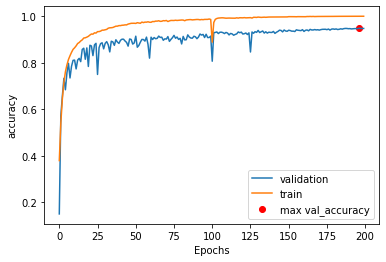

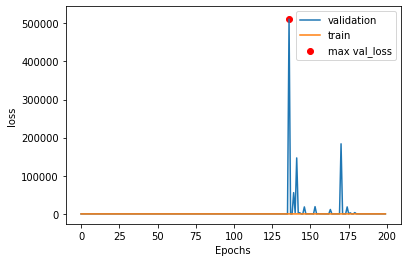

0.0518 in 677.3 min



In [10]:
fitness_cnn.verb = True
score = fitness_cnn.calc(winner, test=True, precise_mode=True)

Without cutout score (200 eps): 0.05180001258850098
Training with 100 eps and cutout
Training with learning rate: 0.05
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32,

Epoch 1/100
390/390 [==============================] - 222s 570ms/step - loss: 1.8566 - accuracy: 0.3675 - val_loss: 3.9876 - val_accuracy: 0.1680
Epoch 2/100
390/390 [==============================] - 201s 514ms/step - loss: 1.5271 - accuracy: 0.5302 - val_loss: 1.2775 - val_accuracy: 0.5765
Epoch 3/100
390/390 [==============================] - 201s 515ms/step - loss: 1.3457 - accuracy: 0.6214 - val_loss: 1.2510 - val_accuracy: 0.5750
Epoch 4/100
390/390 [==============================] - 201s 515ms/step - loss: 1.2198 - accuracy: 0.6822 - val_loss: 1.0042 - val_accuracy: 0.6717
Epoch 5/100
390/390 [==============================] - 201s 515ms/step - loss: 1.1258 - accuracy: 0.7275 - val_loss: 0.8480 - val_accuracy: 0.7405
Epoch 6/100
390/390 [==============================] - 201s 515ms/step - loss: 1.0643 - accuracy: 0.7540 - val_loss: 0.6956 - val_accuracy: 0.7894
Epoch 7/100
390/390 [==============================] - 201s 515ms/step - loss: 1.0139 - accuracy: 0.7783 - val_loss: 1

390/390 [==============================] - 200s 514ms/step - loss: 0.6354 - accuracy: 0.9529 - val_loss: 0.3242 - val_accuracy: 0.9198
Epoch 57/100
390/390 [==============================] - 200s 514ms/step - loss: 0.6167 - accuracy: 0.9594 - val_loss: 0.3322 - val_accuracy: 0.9249
Epoch 58/100
390/390 [==============================] - 200s 514ms/step - loss: 0.6216 - accuracy: 0.9574 - val_loss: 0.3612 - val_accuracy: 0.9139
Epoch 59/100
390/390 [==============================] - 200s 513ms/step - loss: 0.6148 - accuracy: 0.9604 - val_loss: 0.3433 - val_accuracy: 0.9156
Epoch 60/100
390/390 [==============================] - 200s 513ms/step - loss: 0.6105 - accuracy: 0.9621 - val_loss: 0.3043 - val_accuracy: 0.9269
Epoch 61/100
390/390 [==============================] - 200s 513ms/step - loss: 0.6050 - accuracy: 0.9644 - val_loss: 0.2914 - val_accuracy: 0.9314
Epoch 62/100
390/390 [==============================] - 200s 513ms/step - loss: 0.6074 - accuracy: 0.9642 - val_loss: 0.3605 

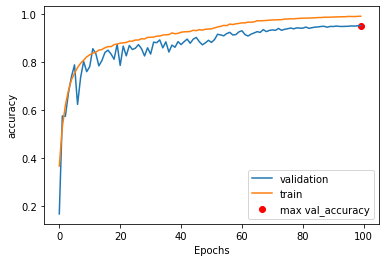

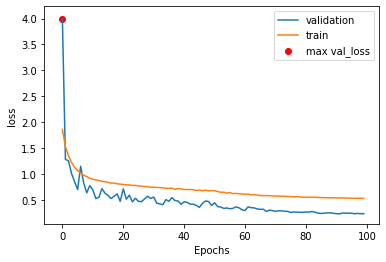

0.0473 in 340.3 min



In [11]:
fitness_cnn.test_eps = 100
fitness_cnn.verb = True
print("Without cutout score (200 eps):", score)
if float(score) < 0.0449:
    fitness_cnn.augment = True
    print("Training with 100 eps and without cutout")
else:
    fitness_cnn.augment = 'cutout'
    print("Training with 100 eps and cutout")
    
score = fitness_cnn.calc(winner, test=True, precise_mode=True)

(50000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10) (10000, 10)


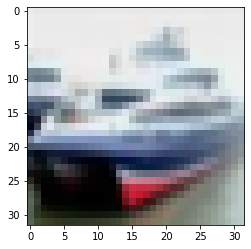

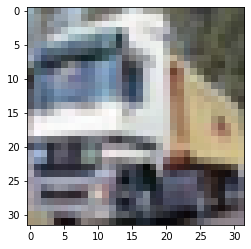

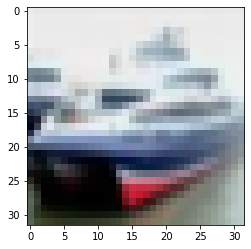

In [21]:
print(fitness_cnn.x_train.shape, fitness_cnn.x_test.shape, fitness_cnn.x_val.shape)
print(fitness_cnn.y_train.shape, fitness_cnn.y_test.shape, fitness_cnn.y_val.shape)


x = (fitness_cnn.x_test[1], fitness_cnn.x_train[1], fitness_cnn.x_val[1])
import matplotlib.pyplot as plt
plt.imshow(x[0]); plt.show()
plt.imshow(x[1]); plt.show()
plt.imshow(x[2]); plt.show()

for xi in fitness_cnn.x_train:
    if np.sum(xi == x) == 32*32*3:
        print("Puta la wea")
        break


In [ ]:

winner = generational.best_individual['winner']
fitness_cnn.verb = True
print(p)
score = fitness_cnn.calc(p, test=True, precise_mode=True, augmnt=True)

||CNN|F:0.7|K:3|A:prelu|D:0.15||woCAT||1||
||CNN|F:0.9|K:5|A:relu|D:0.05||woCAT||01||
||CNN|F:0.8|K:3|A:relu|D:0.70||SUM||011||
||CNN|F:0.5|K:5|A:elu|D:0.10||SUM||1011||
HP->|GR:2.65|CELL:2|BLOCK:2|STEM:64

Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
_____________________________________________________

Epoch 1/200
390/390 [==============================] - 163s 419ms/step - loss: 1.9223 - accuracy: 0.3666 - val_loss: 3.5652 - val_accuracy: 0.1654
Epoch 2/200
390/390 [==============================] - 142s 365ms/step - loss: 1.6269 - accuracy: 0.5512 - val_loss: 1.2367 - val_accuracy: 0.5861
Epoch 3/200
 76/390 [====>.........................] - ETA: 1:48 - loss: 1.5109 - accuracy: 0.6201

In [ ]:
from keras.datasets import cifar100, cifar10

data = cifar100.load_data()
data2 = cifar10.load_data()



In [ ]:
len(data), len(data2)
len(data[1]), len(data2[1])
type(data[0][0]), type(data2[0][0])
for i in range(2):
    for j in range(2):
        print(data[i][j].shape, data2[i][j].shape)

### Evolve MRDBI 1 cells per block and 1 blocks

In [ ]:
experiments_folder = '../../exp_op_coding_VM3'

experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        generational.print("Experiment with fitness calculation using mean of thee best val accuracies. \
                           \nAlso using limited precision to dropout values")

        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))
    print("Previous elapsed time: %s" % "Generation (24) in 1380.97 minutes.")

In [ ]:
#ChromosomeOp.INITIAL_FILTERS = 64
#ChromosomeOp.CELLS_PER_BLOCK = 1
#ChromosomeOp.N_BLOCKS = 1
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.02
score = generational.fitness_evaluator.calc(winner, test=True, precise_mode=True)

In [ ]:
for k,v in generational.best_individual.items():
    print(k)
    print(v)
    print()
print(winner)

#### Evolution with 2 cells per block and 2 blocks

In [ ]:
datasets = ['cifar10']
experiments_folder = '../../exp_op_coding'

experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    print(generational.generation)
    print(generational.num_generations)
    if generational.generation < generational.num_generations:
        winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
print(generational.best_individual['winner'])

In [ ]:
# Load data
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps)

In [ ]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
fitness_cnn.batch_size= 128
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [ ]:
generational.training_hours = 48
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
ranking1 = generational.evaluate_population(level=1)
ranking2 = generational.evaluate_population(level=2)

In [ ]:
ranking1

In [ ]:
ranking2

In [ ]:
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [ ]:
w = generational.best_individual['winner']
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2

fitness_cnn.precise_epochs = 75
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [ ]:
w = generational.best_individual['winner']
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2

fitness_cnn.precise_epochs = 108
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

#### Evolution with 1 cell per block and 1 block

In [ ]:
experiments_folder = '../../exp_op_coding2'
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        break
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
print(generational.ti/3600)

In [ ]:
# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

In [ ]:
fitness_cnn.verb = True
fitness_cnn.precise_epochs = 75

w = generational.best_individual['winner']
w_copy = w.self_copy()
for block in w_copy.blocks:
    for op in block.ops:
        if op.type() == 'CNN':
            op.k_size = 3

print(w)
print(w_copy)

In [ ]:
  
# ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 1

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [ ]:
print(generational.best_individual)

In [ ]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 2

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [ ]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [ ]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 4

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [ ]:
ChromosomeOp.INITIAL_FILTERS = 32
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

#### Evolution with 1 cells per block and 3 blocks, but 45 filters
##### (and possible kernel sizes: 1, 3 and 5)

In [ ]:
experiments_folder = '../../exp_op_coding3'
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        break
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)
        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


In [ ]:
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

fitness_cnn.precise_epochs = 200
fitness_cnn.verb = True
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [ ]:
generational.paint
generational.filename


In [7]:
780/60


13.0

In [4]:
try:
    a = 3
    

SyntaxError: unexpected EOF while parsing (<ipython-input-4-027ed6f62034>, line 3)